<h1 align="center">Advanced Image Processing and Analysis</h1>
<h3 align="center">ECE 4438B/ECE 9022/ECE 9202B/BIOMED 9519B/BIOPHYS 9519B/CAMI 9519B</h3>
<h4 align="center"><a href="mailto:echen29@uwo.ca"> Elvis Chen, PhD, LL</a></h4>
<h4 align="center">Day 10, February 05, 2019</h4>

### Introduction

Another histogram-based threholding technique is the [Maximum Entropy technique](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1MaximumEntropyThresholdImageFilter.html). We we have seen from the previous examples, **if** there is a clear distinction between the foregraound ($w$) and the background $(b)$, then the histogram is likely to be bimodal and any technique that choose a value within the valley will work reasonably well (such as the [Otsu's method](http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4310076). 

However, gray-level histograms are not always bimodal: methods other than valley-seeking are thus required to select a reasonable threshold value.

In [1]:
import SimpleITK as sitk
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook

# utilities for diplaying images
from myshow import myshow, myshow3d

In [2]:
#img_rgb = sitk.ReadImage('..\\data\\images\\onion.png')
img_rgb = sitk.ReadImage('..\\data\\images\\Lenna.png')
sitk.Show(img_rgb, title='Colour Image')
img_Vector = sitk.GetArrayFromImage( img_rgb ) # copy the pixel to a numpy array

In [3]:
img_bw = sitk.GetImageFromArray(.299 * img_Vector[:,:,0] + .587 * img_Vector[:,:,1] + .114 * img_Vector[:,:,2])
img_bw.CopyInformation( img_rgb ) # why do we do this?
sitk.Show(img_bw)

In [4]:
# althought not necessary here, let us do it as a good practice
img_255 = sitk.Cast(sitk.RescaleIntensity(img_bw), sitk.sitkUInt8) 

Another statistical measure we can use is the **entropy**, borrowed from the communication theory:

In the field of Information Theory, [Shannon's entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory%29) is a measure of randomness. Given a [discrete random variable](https://en.wikipedia.org/wiki/Random_variable#Discrete_random_variable) $X$ with possible values $\{x_i, ..., x_n\}$ (i.e. pixel intensity values) and [probability mass function](https://en.wikipedia.org/wiki/Probability_mass_function) $P(X)$ (i.e. normalized histogram), the entropy can be explicitly be written as:

$H(X) = - \sum_{i=1}^{n} P(x_i) log_{b} P(x_i)$

where $b$ is the base of the logarithm used. Common values of $b$ are $2$, $e$, and $10$, and the corresponding units of entroy are in [bits](https://en.wikipedia.org/wiki/Bit) for $b=2$, [nats](https://en.wikipedia.org/wiki/Nat_(unit%29) for $b=e$, and [bans](https://en.wikipedia.org/wiki/Hartley_(unit)) for $b=10$.

In [5]:
# to calculate the entropy, we need to compute the normalized histogram first
bw_histogram = np.histogram( img_bw, bins=256, range=[0,256] )
PMF = 1.0/np.sum(bw_histogram[0]) * bw_histogram[0]

Text(0.5, 1.0, 'Probability Density Function')

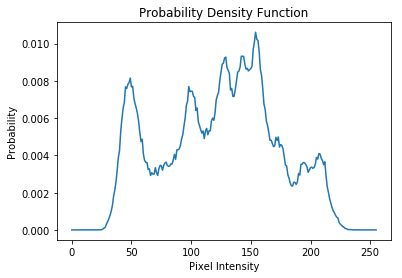

In [6]:
# bw_histogram_normalized = 1.0/(bw_histogram[0].sum()) * bw_histogram[0]
plt.figure()
plt.plot(range(0,256), PMF)
plt.xlabel('Pixel Intensity')
plt.ylabel('Probability')
plt.title('Probability Density Function')

In [7]:
# what is log(0)?
np.log(0)

C:\Users\chene\AppData\Local\conda\conda\envs\sitkpyAIP_UWO_W19\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


-inf

In [8]:
# log(0) will give us a lot of error
np.log(0)

C:\Users\chene\AppData\Local\conda\conda\envs\sitkpyAIP_UWO_W19\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


-inf

In [9]:
entropy = -1.0*np.sum( PMF[np.nonzero(PMF)] * np.log2( PMF[np.nonzero(PMF)]))
print(entropy)

7.445074561920689


In [10]:
# SCIPY has a built-in function for calculating the entropy, but it gives a slightly different number.


import scipy.stats
scipy.stats.entropy(PMF,base=2)

7.4450745619206895

In [a paper by Kapur, Sahoo and Wong](https://www.sciencedirect.com/science/article/pii/0734189X85901252) ([alternative source](http://pequan.lip6.fr/~bereziat/pima/2012/seuillage/kapur85.pdf)), the use of entropy to determine the thresholding value was proposed. The authors noted that the gray-level histogram are not always bimodel, and proposed to select a thresholding value of which the entropies of the distributions **above** and **below** is maximized.

(**for the discussion below, we'll use the same notation as those from [Otsu's paper](http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4310076) for consistency. Note these notation are different than those in Kapur, Shann and Wong's paper**)

Assumes we have a gray scale image with pixel intensity range of $[0...L]$ and a total number of $N$ pixels. Let $n_i$ denote the number of pixels at an intensity level $i$:

$N = n_0 + n_1 + ... + n_L$

Define $p$ be the cumulative density function:

$p_i = \frac{n_i}{N}$

where $f_i$ is the frequency of the pixel intensity (i.e. height of the histogram). Further define:

$w_0 = \sum_{i=0}^t p_i$

and

$1-w_0 = \sum_{i=t+1}^L p_i$

Remember, $w_0$ and $w_1$ represent the areas under the curve: <img src="areaUnderCurve.png" width="550"/> 


For a given pixel intensity $i, i \in [0,t]$, compute

$H_l(i) = - \sum_{i=0}^t \frac{p_i}{w_0} ln \frac{p_i}{w_0}$

and

$H_h(i) = - \sum_{t+1}^L \frac{p_i}{1-w_0} ln \frac{p_i}{1-w_0}$

and define

$H = H_l + H_h$

That is, $H_l(i)$ is the entropy amoung the pixels with intensity lower than $i$, and $H_h(i)$ is the entropy among the pixels with intensity high than $i$. The **maximum entropy** thresholding value $H$ is the maxumum of $H_l+H_h$.

An naive implementation is shown below:

Maximum entropy occurs at intensity: 121


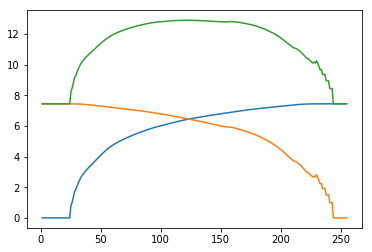

In [11]:
# Compute the cumulative density function CDF
bw_histogram_normalized=PMF
CDF = np.zeros(len(bw_histogram_normalized))
CDF[0] = bw_histogram_normalized[0]
for i in range(1,len(bw_histogram_normalized)):
    CDF[i] = CDF[i-1] + bw_histogram_normalized[i]
    
hl = np.zeros(256)  #entropy for (black) class below the threshold value
hh = np.zeros(256)  #entropy for (white) class above the threshold value
h = np.zeros(256)   #total entropy, sum of the two classes

for t in range(0,len(hl)):
    cl = CDF[t]
    if ( cl > 0 ):
        for i in range(0,t+1):
            if (bw_histogram_normalized[i] > 0):
                hl[t] = hl[t] - (bw_histogram_normalized[i]/cl) * np.log2(bw_histogram_normalized[i]/cl)
            
    ch = 1.0-cl
    if ( ch > 0 ):
        for i in range(t+1,256):
            if ( bw_histogram_normalized[i] > 0 ):
                hh[t] = hh[t] - ( bw_histogram_normalized[i]/ch) * np.log2(bw_histogram_normalized[i]/ch)
                
    h[t] = hl[t] + hh[t] # total entropy
    

plt.figure()
plt.plot(range(1,256),  hl[1:])
plt.plot(range(1,256),  hh[1:])
plt.plot(range(1,256),  h[1:])
print('Maximum entropy occurs at intensity:', np.argmax(h))

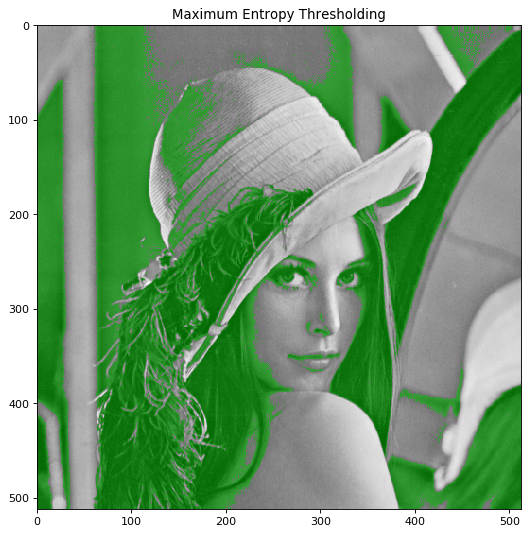

121.63159677124023


In [12]:
MaxEntropy_Filter = sitk.MaximumEntropyThresholdImageFilter()
MaxEntropy_Filter.SetInsideValue(1)
MaxEntropy_Filter.SetOutsideValue(0)
seg = MaxEntropy_Filter.Execute(img_bw)
myshow(sitk.LabelOverlay(img_255, seg), "Maximum Entropy Thresholding")
print(MaxEntropy_Filter.GetThreshold())

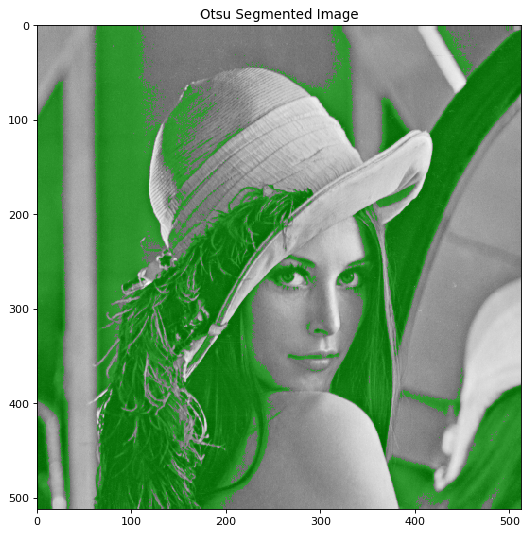

116.90564462280273


In [13]:
otsu_filter = sitk.OtsuThresholdImageFilter()
inside_value = 1
outside_value = 0
otsu_filter.SetInsideValue(inside_value)
otsu_filter.SetOutsideValue(outside_value)
seg = otsu_filter.Execute(img_bw)
myshow(sitk.LabelOverlay(img_255, seg), title='Otsu Segmented Image') # the image is too large to use myshow
print( otsu_filter.GetThreshold())